In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import random
import torch.optim as optim
from torch.utils.data import DataLoader
import time
import networkx as nx
from tqdm import tqdm

def load_data(filename):
  n = 0
  matrix_count = 0
  data = []
  with open(filename) as fin:
    cur_matrix = []
    for i, line in enumerate(fin):
      if i == 0:
        line  = line.split()
        n = int(line[0])
        #matrix_count = int(line[1])
      elif i % (n + 1) != 0:
        cur_matrix.append([float(j) for j in line.split()])
      else:
        print (i)
        data.append(np.array([cur_matrix]))
        cur_matrix = []
        if len(data) >= 6900:
          break


  data = np.array(data)
  return data


In [ ]:
!unzip output.zip

unzip:  cannot find or open output.zip, output.zip.zip or output.zip.ZIP.


In [ ]:
def load_matrix(filename):
  n = 0
  matrix_count = 0
  data = []
  with open(filename) as fin:
    cur_matrix = []
    for i, line in enumerate(fin):
      if i == 0:
        line  = line.split()
        n = int(line[0])
        #matrix_count = int(line[1])
      elif i % (n + 1) != 0:
        cur_matrix.append([float(j) for j in line.split()])
      else:
        data.append(cur_matrix)
        cur_matrix = []
        if len(data) >= 6900:
          break

  return data

In [ ]:
adv_matrix = load_matrix('output2.txt')
print(len(adv_matrix))

6900


In [ ]:
dataset = load_data('output2.txt')
print(dataset.shape)

Streaming output truncated to the last 5000 lines.
17118
17127
17136
17145
17154
17163
17172
17181
17190
17199
17208
17217
17226
17235
17244
17253
17262
17271
17280
17289
17298
17307
17316
17325
17334
17343
17352
17361
17370
17379
17388
17397
17406
17415
17424
17433
17442
17451
17460
17469
17478
17487
17496
17505
17514
17523
17532
17541
17550
17559
17568
17577
17586
17595
17604
17613
17622
17631
17640
17649
17658
17667
17676
17685
17694
17703
17712
17721
17730
17739
17748
17757
17766
17775
17784
17793
17802
17811
17820
17829
17838
17847
17856
17865
17874
17883
17892
17901
17910
17919
17928
17937
17946
17955
17964
17973
17982
17991
18000
18009
18018
18027
18036
18045
18054
18063
18072
18081
18090
18099
18108
18117
18126
18135
18144
18153
18162
18171
18180
18189
18198
18207
18216
18225
18234
18243
18252
18261
18270
18279
18288
18297
18306
18315
18324
18333
18342
18351
18360
18369
18378
18387
18396
18405
18414
18423
18432
18441
18450
18459
18468
18477
18486
18495
18504
18513
18522
18531
1

In [ ]:
dataloader = DataLoader(dataset, batch_size= 16, shuffle= True, drop_last= True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
def sigm(x):
    if x < 0.5:
        return 0.0
    return 1.0

In [ ]:
class GraphEncoder(nn.Module):
  def __init__(self, n):
    super(GraphEncoder, self).__init__()
    self.repeat = 5
    self.n = n
    self.layers = []
    for i in range(self.repeat):
      self.layers.append(nn.Linear(in_features= 2 * i * self.n + np.power(self.n, 2), out_features= 2 * (i + 1) * self.n + np.power(self.n, 2)))
      self.layers.append(nn.LeakyReLU(inplace= True))
    self.main = nn.Sequential(
        *self.layers
    )

  def forward(self, A):
    A = torch.flatten(A, 1)
    batch_shape = A.size()
    X = self.main(A).reshape(batch_shape[0], 1, self.n, -1)
    return X

class GraphDecoder(nn.Module):
  def __init__(self, n):
    super(GraphDecoder, self).__init__()
    self.repeat = 5
    self.n = n
    self.layers = []
    for i in range(self.repeat):
      self.layers.append(nn.Linear(in_features= 2 * (self.repeat - i) * self.n + np.power(self.n, 2), out_features= 2 * (self.repeat - i - 1) * self.n + np.power(self.n, 2)))
      self.layers.append(nn.LeakyReLU(inplace= True))

    self.main = nn.Sequential(
        *self.layers,
        nn.Sigmoid()
    )

  def forward(self, X):
    X = torch.flatten(X, 1)
    X = self.main(X)
    A = X.view(X.size(0), 1, self.n, self.n)
    return A

loss_epochs = []

class GraphAutoEncoder(nn.Module):
  def __init__(self, n):
    self.n = n
    super(GraphAutoEncoder, self).__init__()
    self.encoder = GraphEncoder(self.n)
    self.decoder = GraphDecoder(self.n)
    self.EPOCH = 20
    self.optimizer = optim.Adam(self.parameters(), lr= 1e-3)

  def train(self):
   for epoch in range(self.EPOCH):
    loss_epoch = []
    start = time.time()
    for matrix_batch in dataloader:
      matrix_batch = matrix_batch.to(device)

      self.optimizer.zero_grad()

      lattente_batch = self.encoder(matrix_batch.float())
      fake_batch = self.decoder(lattente_batch)

      mse_loss = nn.MSELoss()

      loss = mse_loss(matrix_batch.float(), fake_batch)
      loss.backward()
      loss_epoch.append(loss.item())
      self.optimizer.step()

    loss = sum(loss_epoch) / len(loss_epoch)
    loss_epochs.append(loss)

    print('time epoch ', epoch, ' ', 'loss', loss,  time.time() - start)


In [ ]:
graphAE = GraphAutoEncoder(8).to(device)
graphAE.train()

time epoch  0   loss 0.2321122219211264 1.5634596347808838
time epoch  1   loss 0.2113710872465939 1.5148911476135254
time epoch  2   loss 0.20789177912847073 1.5372788906097412
time epoch  3   loss 0.20707289981731405 1.523972511291504
time epoch  4   loss 0.2059042434058997 1.5884051322937012
time epoch  5   loss 0.2046249892968866 1.7029941082000732
time epoch  6   loss 0.20338360142403578 2.3735814094543457
time epoch  7   loss 0.20228381271705273 1.8017146587371826
time epoch  8   loss 0.20122537974553428 1.5413963794708252
time epoch  9   loss 0.1994059979915619 2.9635658264160156
time epoch  10   loss 0.19648213919658394 4.156816720962524
time epoch  11   loss 0.19438018451019118 4.094724416732788
time epoch  12   loss 0.19276840234577242 1.5646796226501465
time epoch  13   loss 0.19258609524735718 1.5747778415679932
time epoch  14   loss 0.19133757573407653 2.0633416175842285
time epoch  15   loss 0.1912487079745932 2.082453727722168
time epoch  16   loss 0.1939431333140818 1.5

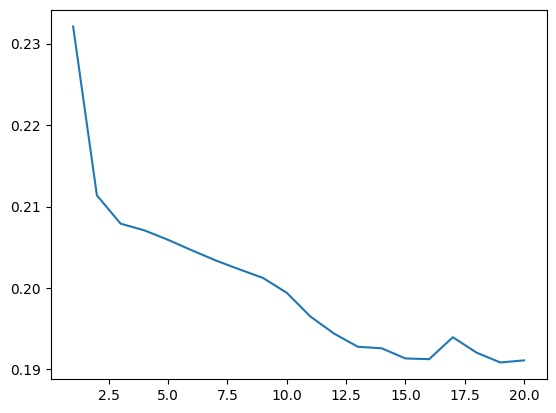

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, 21), loss_epochs)
plt.show()

In [ ]:
for batch in dataloader:
  batch = batch.to(device)
  print(batch.size())
  print(batch[0][0].detach().cpu().numpy())
  lattente = graphAE.encoder(batch.float())
  print(lattente[0].detach().cpu().numpy())
  fake_batch = graphAE.decoder(lattente.float())
  matrix = fake_batch[0][0].detach().cpu().numpy()
  for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            matrix[i][j] = sigm(matrix[i][j])
  print(matrix)
  break

torch.Size([16, 1, 8, 8])
[[0. 1. 0. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 1. 1. 1. 0.]
 [1. 0. 0. 0. 0. 1. 1. 1.]
 [1. 1. 1. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 1.]
 [1. 0. 0. 1. 1. 0. 1. 0.]]
[[[-5.1342463e-03 -8.3967466e-03 -2.4311556e-03 -2.4861298e-04
   -3.8345149e-03 -8.2374597e-03 -9.5928749e-03 -3.9650807e-03
   -5.5878209e-03 -3.6719050e-03 -1.0657440e-02 -3.6114457e-03
   -4.1042841e-03 -1.3384976e-03 -2.6464611e-03 -1.3152988e-03
    2.8053877e-01 -2.0514971e-03]
  [-4.2207614e-03 -4.1475738e-03 -3.1713163e-03 -2.5326796e-03
    5.0351471e-01 -3.0559741e-03 -1.5270690e-03 -1.2039940e-03
   -6.7154933e-03  5.2848172e-01  3.7121868e-01  4.0072975e-01
   -3.6574746e-03 -1.6779101e-03 -3.0550659e-03  3.5898197e-02
    1.0027221e+00 -2.0537002e-03]
  [-2.4252161e-03 -6.1785579e-03 -8.6672483e-03 -1.7835420e-03
   -2.2141926e-03  1.4758623e-01  2.3830506e-01 -5.1978505e-03
   -7.4863043e-03 -4.5305328e-03  9.8597783e-01 -8.4842928e

In [ ]:
#testing autoencoder
with torch.no_grad():
  batch_matrix = next(iter(dataloader))
  fake_matrix = graphAE.decoder(graphAE.encoder(batch_matrix.float()))
  for matrix in fake_matrix:
    print(matrix.numpy()[0])

[[4.2527848e-31 6.7553478e-03 2.8725037e-01 4.3658468e-01 4.0836051e-01
  3.3425182e-01 7.1638284e-21 3.8101366e-01]
 [8.6059896e-03 2.9907518e-28 1.3119906e-02 4.4319716e-01 4.3032071e-01
  4.8933551e-01 1.3923922e-02 4.4201040e-01]
 [3.0906749e-01 1.5701808e-02 1.7197773e-29 2.2257191e-01 2.7303582e-01
  2.7488300e-01 1.0000000e+00 2.1550225e-01]
 [4.2384261e-01 4.5858684e-01 1.5314634e-01 1.6563633e-28 2.7479845e-01
  2.3333703e-01 4.2027262e-01 2.7422947e-01]
 [3.8849378e-01 3.5496405e-01 2.3771654e-01 2.4864703e-01 3.4533508e-31
  3.0444092e-01 3.4558612e-01 3.2283977e-01]
 [4.2703170e-01 4.3911523e-01 2.9734981e-01 2.5136822e-01 2.9953432e-01
  1.6873359e-31 2.9485914e-01 3.3714497e-01]
 [2.4716988e-18 1.6826462e-02 1.0000000e+00 3.7854818e-01 3.5617295e-01
  2.9054657e-01 1.1372028e-28 4.1309685e-01]
 [3.7345049e-01 4.7131756e-01 1.8225440e-01 2.6705757e-01 3.1328833e-01
  3.4985560e-01 3.9986143e-01 3.5717901e-31]]
[[0.03263248 1.         0.9702378  0.48787782 0.4785769  0.4813

In [ ]:
#testing decoder
with torch.no_grad():
  for i in range(40):
    noise_batch = torch.randn(16, 1, graphAE.n, 2 * (graphAE.decoder.repeat) + graphAE.n).to(device)
    matrix_batch = graphAE.decoder(noise_batch)
    for matrix in matrix_batch:
      A = matrix.numpy()[0]
      for i in range(len(A)):
        for j in range(len(A[0])):
          if A[i][j] < 0.5:
            A[i][j] = 0
          else:
            A[i][j] = 1
      print(A)

Streaming output truncated to the last 5000 lines.
[[0. 0. 0. 1. 1. 1. 0. 1.]
 [0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 1. 1. 1. 1. 0. 1.]
 [0. 0. 0. 1. 1. 1. 0. 1.]
 [1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 0. 1.]
 [1. 1. 0. 0. 0. 0. 1. 0.]]
[[0. 1. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]
[[0. 0. 1. 0. 1. 1. 0. 1.]
 [0. 0. 1. 0. 1. 1. 0. 1.]
 [1. 1. 0. 0. 0. 1. 1. 0.]


In [ ]:
def GetEmbedingMatrix(A):
  D = np.zeros(len(A))
  for i in range(A.shape[0]):
    for j in range(A.shape[1]):
      if A[i][j] == 1:
        D[i] += 1

  D = D.reshape(len(D), -1)
  A = np.hstack((D, A))
  return A

def GetEmbedingMatrixBatch(batch_A):
  embeding_batch = []
  for A in batch_A:
    A = A[0].detach().cpu().numpy()
    embeding_batch.append([GetEmbedingMatrix(A)])

  return torch.tensor(embeding_batch)

def GetEmbedingWithLattenteMatrixBatch(batch_A):
  batch_A = batch_A.to(device)
  X = GetEmbedingMatrixBatch(batch_A)
  L = graphAE.encoder(batch_A).view(batch_A.size(0), 1, graphAE.n, -1)
  embeding_batch = []
  for i in range(len(batch_A)):
    embeding_batch.append([np.hstack((X.detach().cpu().numpy()[i][0], L.detach().cpu().numpy()[i][0]))])

  return torch.tensor(embeding_batch)

def GetMatrixEmbeding(batch_X):
  batch_A = graphAE.decoder(batch_X)
  batch = []
  for matrix in batch_A:
    matrix = matrix.detach().cpu().numpy()[0]
    for i in range(matrix.shape[0]):
      for j in range(matrix.shape[1]):
        if matrix[i][j] + matrix[j][i] < 1:
          matrix[i][j] = 0
          matrix[j][i] = 0
        else:
          matrix[i][j] = 1
          matrix[j][i] = 1
    batch.append([matrix])

  return torch.tensor(batch)

def GetDPlusA(A):
    for i in range(A.size(1)):
        s = sum(A[i])
        A[i][i] -= s

    return A

def GetDPlusABatch(batch_A):
    for i in range(batch_A.size(0)):
        batch_A[i][0] = GetDPlusA(batch_A[i][0])

    return batch_A

class GraphConvLayer(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(GraphConvLayer, self).__init__()
    self.main = nn.Sequential(
        nn.Linear(in_features= input_dim, out_features= output_dim, bias= False),
        nn.ReLU(inplace= True)
        )

  def forward(self, A, X):
    AX = A @ X
    AX = AX.reshape(A.size(0), -1)
    AXW = self.main(AX).reshape(A.size(0), 1, A.size(2), -1)
    return AXW


class Discriminator(nn.Module):
  def __init__(self):
    self.conv_dim = 16
    self.repeat = 3
    self.n = 8
    self.embeding_len = 216
    super(Discriminator, self).__init__()
    self.layers = []
    for i in range(self.repeat):
      self.layers.append(GraphConvLayer(input_dim = self.embeding_len, output_dim= self.embeding_len))

    self.cls = nn.Sequential(
        nn.Linear(in_features= self.embeding_len, out_features= 1),
        nn.Sigmoid()
    )

  def forward(self, A, X):
      for i in range(self.repeat):
        X = self.layers[i](A, X)

      X = X.reshape(X.size(0), -1)
      cls = self.cls(X)

      return cls

class Generator(nn.Module):
  def __init__(self):
    self.embeding_len = 144
    self.repeat = 3
    self.n = 8
    #self.AE = graphAE()
    super(Generator, self).__init__()
    self.layers = []
    for i in range(self.repeat):
      self.layers.append(nn.Linear(in_features= self.embeding_len, out_features= self.embeding_len, bias= False))
      self.layers.append(nn.ReLU(inplace= True))

    self.main = nn.Sequential(*self.layers,
                              nn.Sigmoid()
                             )

  def forward(self, X):
    X = X.reshape(X.size(0), -1)
    X = self.main(X)
    X = X.reshape(X.size(0), 1, self.n, -1)
    A = GetMatrixEmbeding(X)
    D = torch.sum(A, dim= 2)
    D = torch.unsqueeze(D, dim= 3)
    X = torch.cat([D, A, X], dim= 3)
    return A, X

testA = torch.zeros((8, 8))
edges_count = 10
vertexes_from = random.choices(range(8), k= edges_count)
vertexes_to = random.choices(range(8), k= edges_count)
for i in range(edges_count):
  if vertexes_from[i] != vertexes_to[i]:
    testA[vertexes_from[i]][vertexes_to[i]] = 1

testA = torch.unsqueeze(torch.unsqueeze(testA, dim= 0), dim= 0)
testX = GetEmbedingWithLattenteMatrixBatch(testA).float()
print(testX.shape)
Discriminator()(testA, testX).size()

torch.Size([1, 1, 8, 27])


torch.Size([1, 1])

In [ ]:
noise_batch = torch.randn(16, 1, graphAE.n, 2 * graphAE.decoder.repeat + graphAE.n)
testA, testX = Generator()(noise_batch)

In [ ]:
noise_batch = torch.randn(16, 1, graphAE.n, 2 * graphAE.decoder.repeat + graphAE.n)

In [ ]:
with torch.no_grad():
  batch_matrix = next(iter(dataloader))
  embeding_batch = GetEmbedingWithLattenteMatrixBatch(batch_matrix.float())
  print(embeding_batch.size())

torch.Size([16, 1, 8, 27])


In [ ]:
noise_batch = torch.randn(batchA.size(0), 1, graphAE.n, 2 * graphAE.decoder.repeat + graphAE.n)
fakeA, fakeX = generator(noise_batch)

fakeA = GetDPlusABatch(fakeA)
print(fakeA[0][0])

tensor([[-3.,  0.,  0.,  1.,  1.,  1.,  0.,  0.],
        [ 0., -1.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0., -2.,  0.,  0.,  1.,  0.],
        [ 1.,  0.,  0.,  0., -2.,  0.,  1.,  0.],
        [ 1.,  0.,  0.,  0.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  1.,  0., -2.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


g_optimizer = torch.optim.Adam(generator.parameters(), lr= 1e-3)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr= 1e-3)

In [ ]:
EPOCHS = 20
d_loss = []
g_loss = []
g_step = 1
d_step = 4
loss = nn.BCELoss()

real_label = 1.0
fake_label = 0.0

for epoch in range(EPOCHS):
  d_loss_epoch = []
  g_loss_epoch = []
  for i, batchA in enumerate(tqdm(dataloader)):
    #training discriminator
    if i % d_step == 0:
      discriminator.zero_grad()

      batchA = batchA.to(device).float()
      batchX = GetEmbedingWithLattenteMatrixBatch(batchA.float()).float()

      noise_batch = torch.randn(batchA.size(0), 1, graphAE.n, 2 * graphAE.decoder.repeat + graphAE.n)
      fakeA, fakeX = generator(noise_batch)

      batchA = GetDPlusABatch(batchA)
      fakeA = GetDPlusABatch(fakeA)

      label = torch.full((batchA.size(0),), real_label, device= device)
      pred = discriminator(batchA, batchX).view(-1)

      real_loss = loss(pred, label)
      real_loss.backward()

      label.fill_(fake_label)
      pred = discriminator(fakeA, fakeX).view(-1)

      fake_loss = loss(pred, label)
      fake_loss.backward()

      disc_loss = real_loss.mean() + fake_loss.mean()

      d_optimizer.step()

    if i % g_step == 0:
      #training generator
      generator.zero_grad()

      noise_batch = torch.randn(batchA.size(0), 1, graphAE.n, 2 * graphAE.decoder.repeat + graphAE.n)
      fakeA, fakeX = generator(noise_batch)

      fakeA = GetDPlusABatch(fakeA)

      label.fill_(real_label)
      pred = discriminator(fakeA, fakeX).view(-1)

      gen_loss = loss(pred, label)

      gen_loss.backward()
      g_optimizer.step()

      gen_loss = gen_loss.mean()


    d_loss_epoch.append(disc_loss.item())
    g_loss_epoch.append(gen_loss.item())

  d_loss.append(sum(d_loss_epoch) / len(d_loss_epoch))
  g_loss.append(sum(g_loss_epoch) / len(g_loss_epoch))

100%|██████████| 431/431 [00:11<00:00, 36.45it/s]


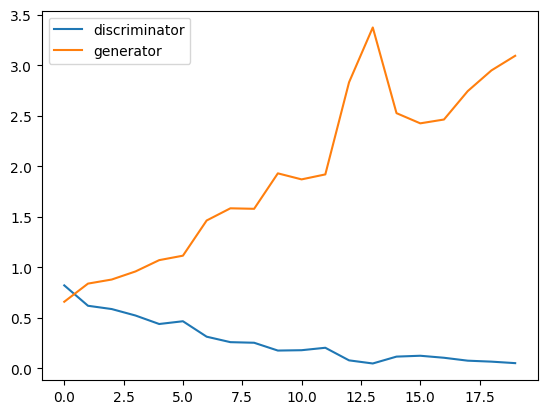

In [ ]:
plt.plot(range(len(d_loss)), d_loss, label= 'discriminator')

plt.plot(range(len(g_loss)), g_loss, label= 'generator')
plt.legend(loc= 'upper left')

plt.show()

new


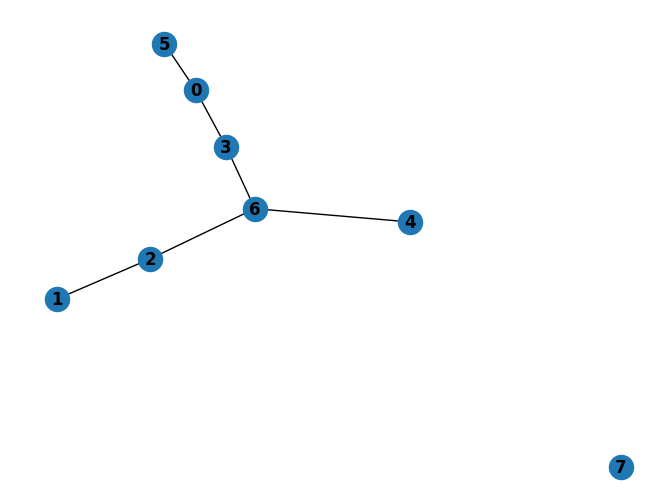


new


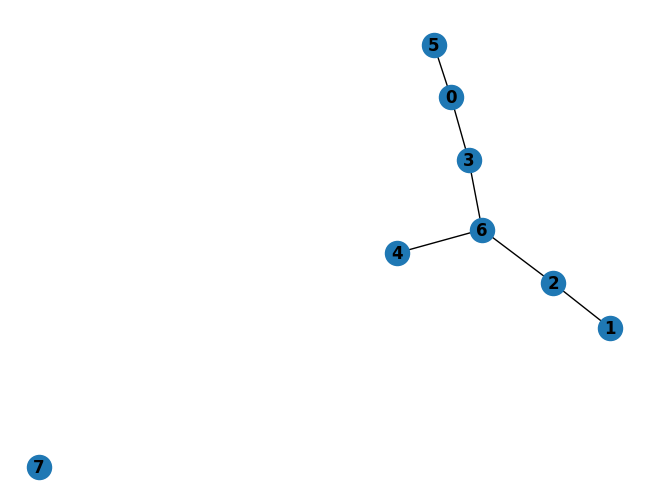


new


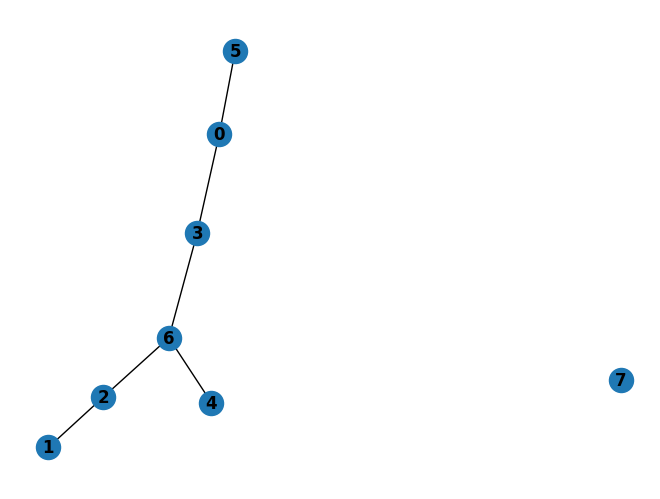


new


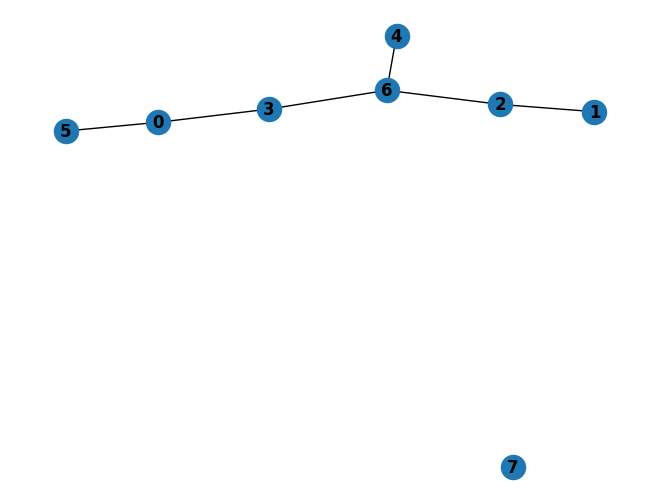


new


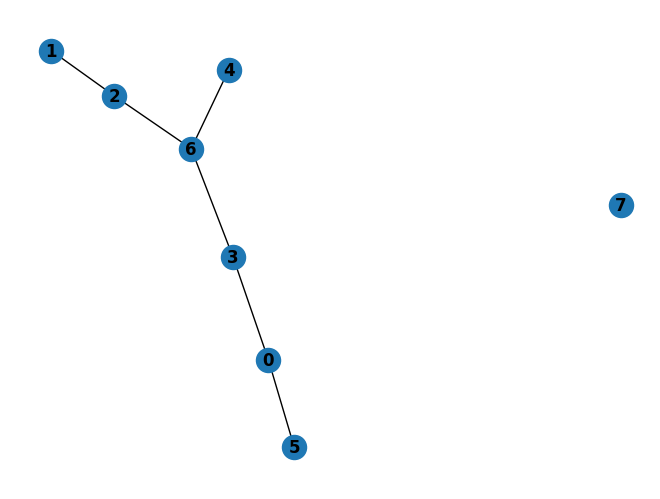


new


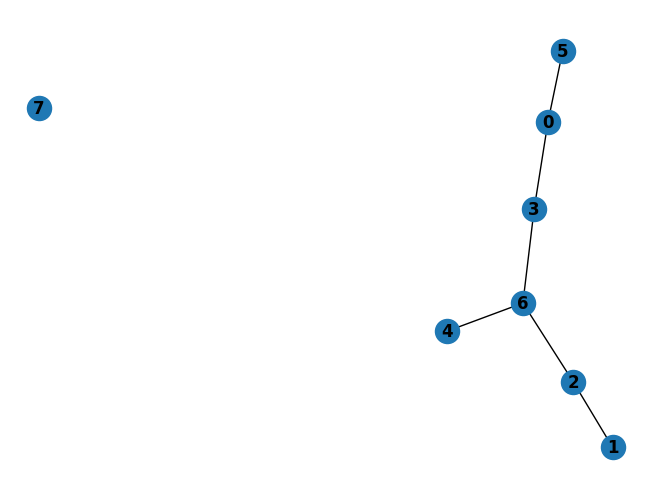


new


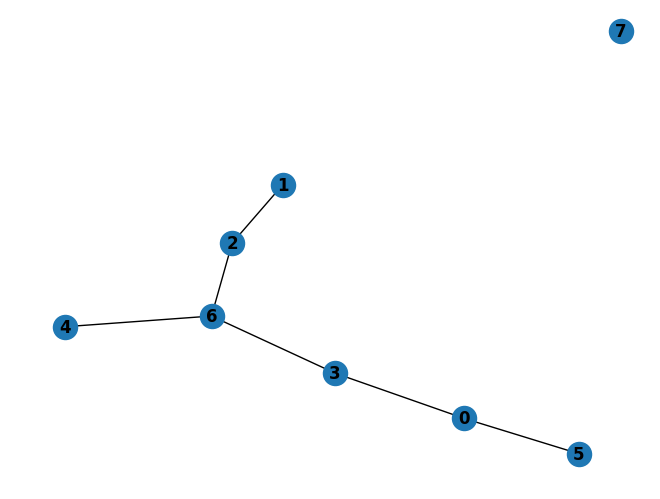


new


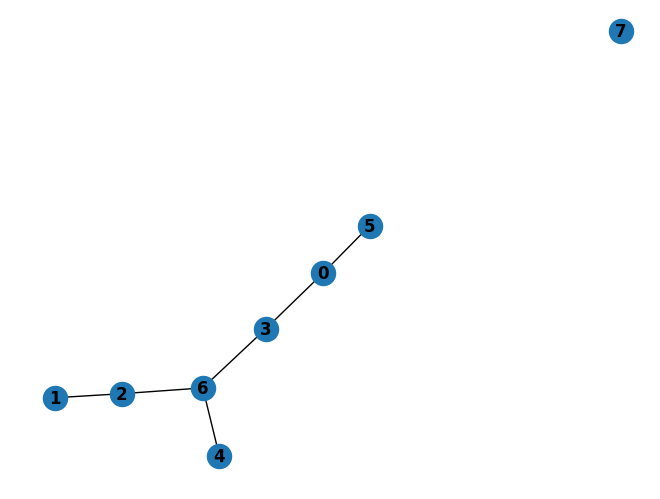


new


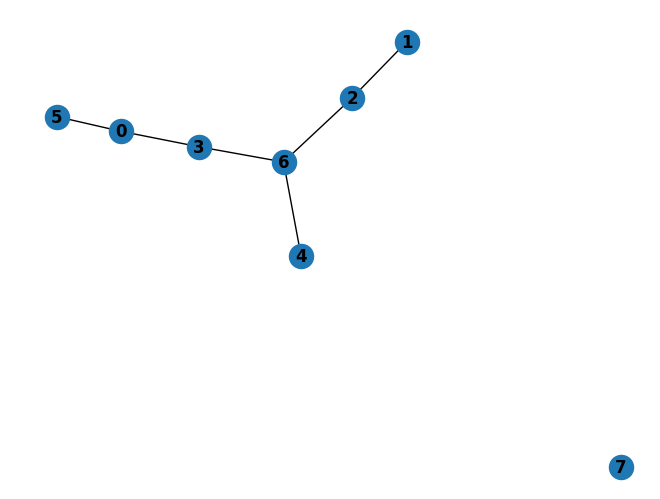


new


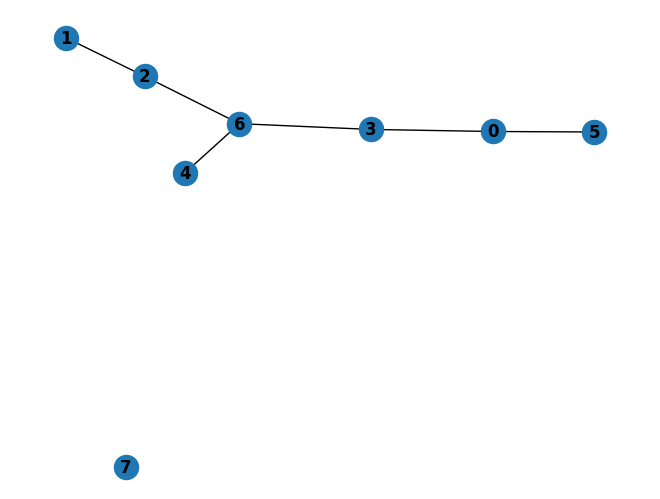


new


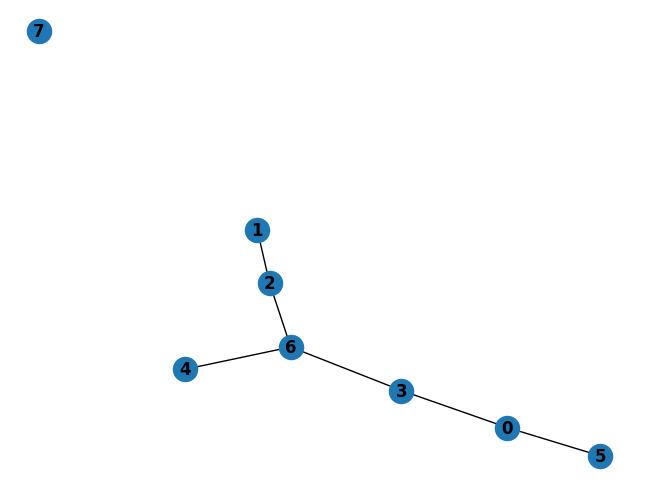


new


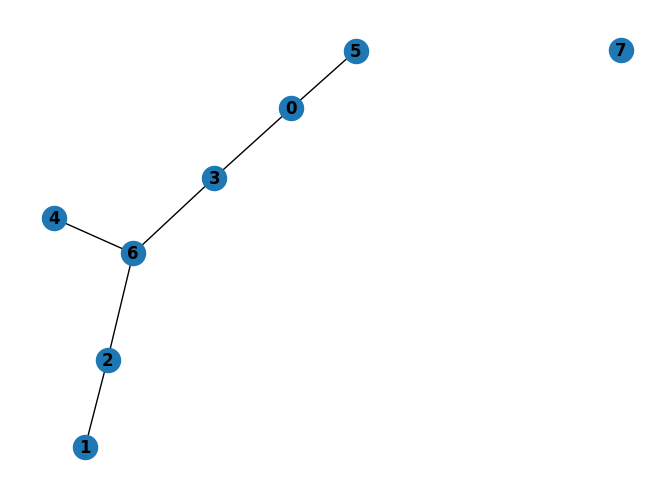


new


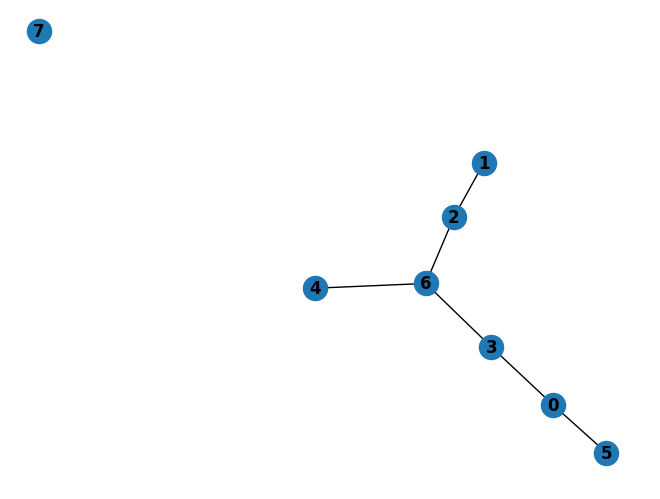


new


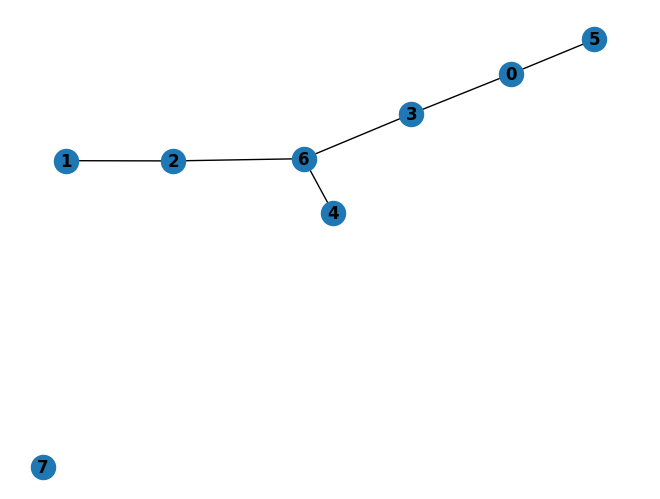


new


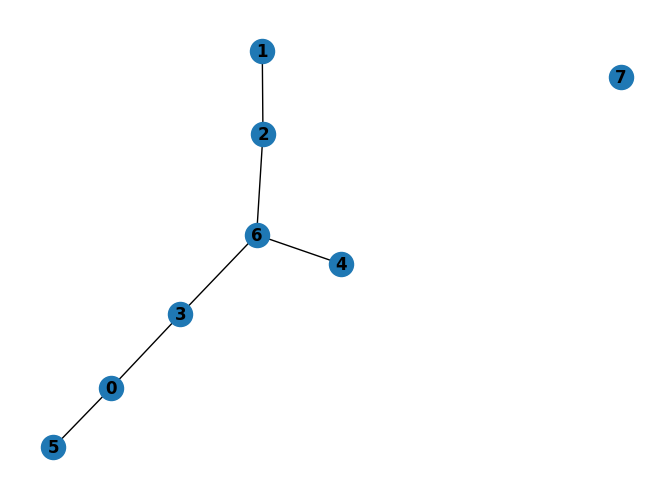


new


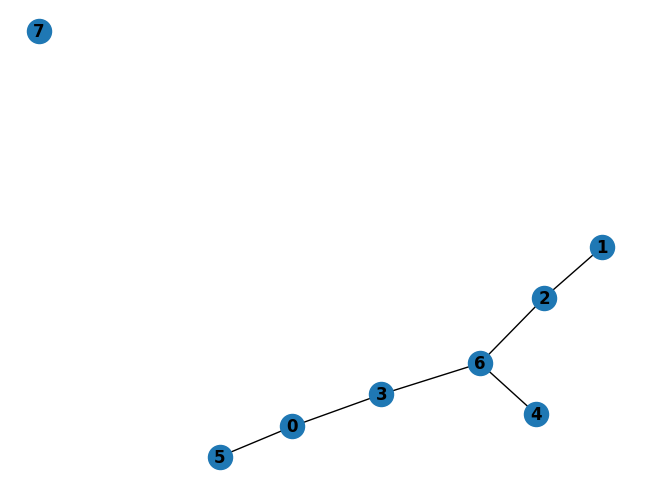

In [ ]:
with torch.no_grad():
    noise_batch = torch.randn(16, 1, graphAE.n, 2 * (graphAE.decoder.repeat) + graphAE.n).to(device)
    matrix_batch,_ = generator(noise_batch)
    for matrix in matrix_batch:
      A = matrix.numpy()[0]
      g = nx.Graph(A)
      prob = A.copy()
      for i in range(len(A)):
        for j in range(len(A[0])):
          if A[i][j] < 0.5 or i == j:
            A[i][j] = 0
          else:
            A[i][j] = 1


      A = [list(x) for x in A]
      in_dataset = adv_matrix.index(A) if A in adv_matrix else 'new'
      print(in_dataset)
      #print(A)
      #plt.imshow(A)
      nx.draw(g, with_labels= True, font_weight= 'bold')
      plt.show()
      print()

In [ ]:
!pip install netron

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.0 MB/s eta 0:00:00


In [ ]:
!pip install onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 49.6 MB/s eta 0:00:00


In [ ]:
import os
import netron
import torch
import torch.onnx

for param in discriminator.parameters():
    param.requires_grad = False

noise_batch = torch.randn(batchA.size(0), 1, graphAE.n, 2 * graphAE.decoder.repeat + graphAE.n)
generator_path = os.path.join('inception_block.onnx')
torch.onnx.export(GraphEncoder(8), fakeA.detach(), generator_path,
                  input_names=['input'], output_names=['output'], opset_version=10)

netron.start(generator_path)

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Serving 'inception_block.onnx' at http://localhost:8081


('localhost', 8081)